# Kex spiking experiment

> Can infrared spectroscopy detect Kex content?

In [722]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Imports

In [723]:
from pathlib import Path

from sklearn.pipeline import Pipeline
from lssm.loading import load_nir_kex_spike, load_mir_kex_spike

from lssm.preprocessing import (ContinuumRemoval, SpikeDiff, 
                                TakeDerivative, MeanCenter, MinScaler, BaselineALS)
from lssm.visualization import plot_spectra


from sklearn.decomposition import PCA, KernelPCA

import warnings
warnings.filterwarnings('ignore')


In [724]:
pd.set_option('display.max_rows', 50)

## Data loading & preprocessing

In [725]:
smp_type = 'MIR'

if smp_type == 'MIR':
    src_dir = Path().home() / 'pro/data/k-spiking/mir'
    X, wavenumbers, names = load_mir_kex_spike(src_dir)
    
else:
    fname = Path().home() / 'pro/data/k-spiking/nir/2023-12-8 _FT-NIR-K-spiked soil.xlsx'
    X, wavenumbers, names = load_nir_kex_spike(fname)

print('X shape: ', X.shape)
print('First 10 wavenumbers: ', wavenumbers[:10])
print('First 5 names: ', names[:5])

X shape:  (58, 1738)
First 10 wavenumbers:  [649.8933 651.8218 653.7502 655.6787 657.6072 659.5356 661.4641 663.3926
 665.321  667.2495]
First 5 names:  ['LUI-0-0' 'LUI-0-1' 'LUI-0-2' 'LUI-0-3' 'LUI-0-4']


In [726]:
mask_smp = np.char.find(names, 'SPA') == 0
X = X[mask_smp, :]
names = names[mask_smp]

In [731]:
pipe = Pipeline([
    ('cr', ContinuumRemoval(wavenumbers)),
    ('diffs', SpikeDiff(names))])

pipe = Pipeline([
    ('cr', BaselineALS()),
    ('diffs', SpikeDiff(names))])

pipe = Pipeline([
    ('cr', BaselineALS())])

pipe = Pipeline([
    ('center', MeanCenter())])
# pipe = Pipeline([
#     ('derivative', TakeDerivative(window_length=31)),
#     ('diffs', SpikeDiff(names))])

# pipe = Pipeline([
#     ('derivative', TakeDerivative(window_length=21))
#     ])

# pipe = Pipeline([
#     ('diffs', SpikeDiff(names))])

X_t = pipe.fit_transform(X)

<Figure size 640x480 with 0 Axes>

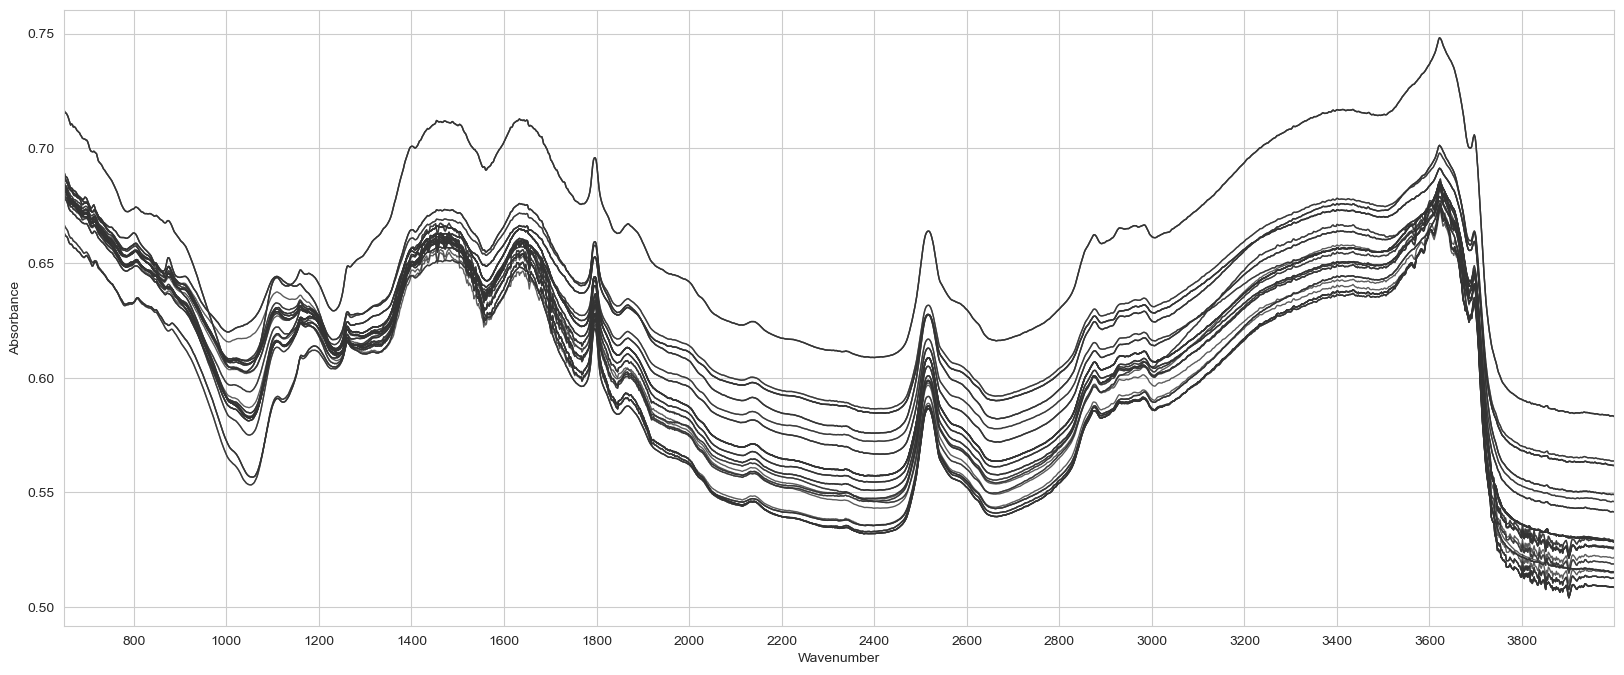

In [732]:
plot_spectra(X, wavenumbers, figsize=(20, 8))

<Figure size 640x480 with 0 Axes>

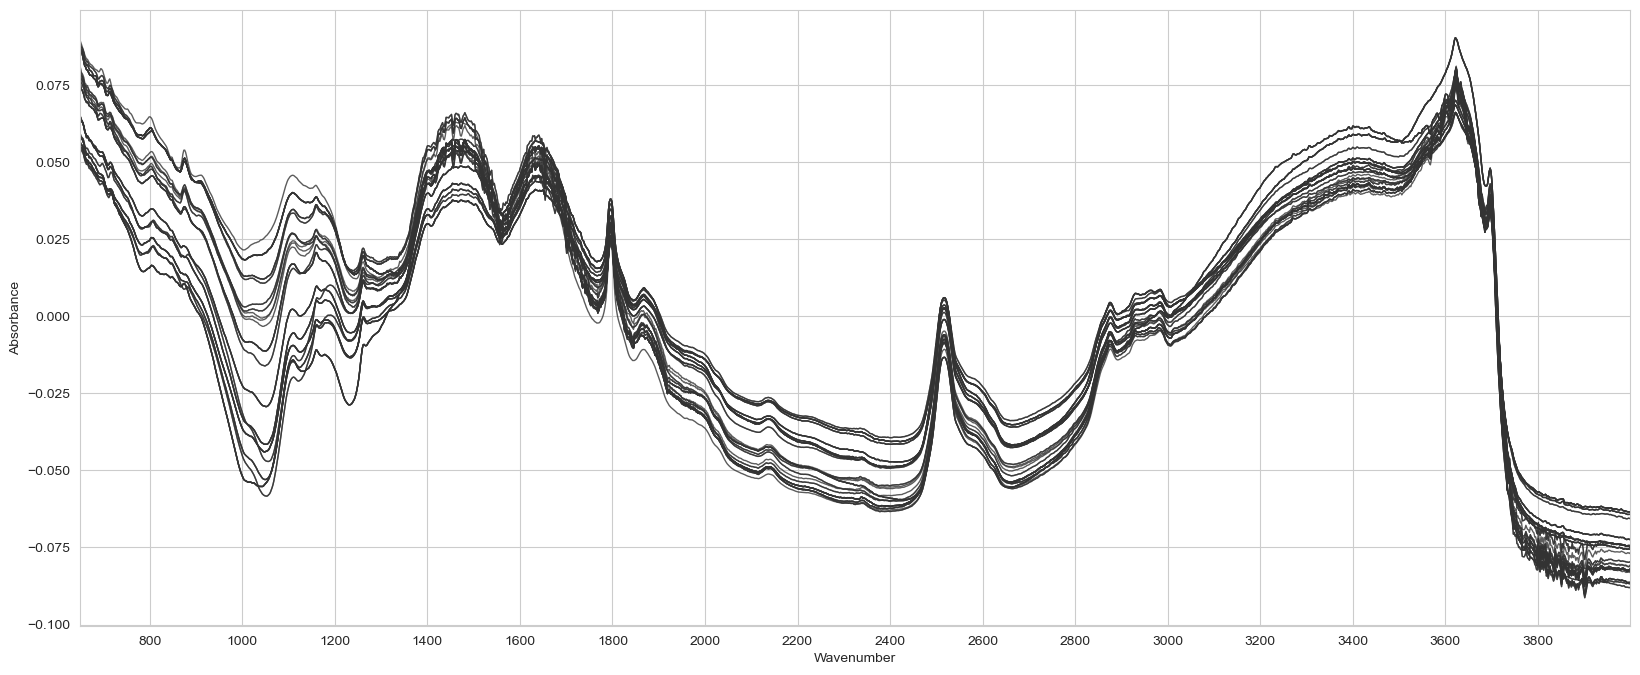

In [733]:
plot_spectra(X_t, wavenumbers, figsize=(20, 8))

In [735]:
n_components = 20
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

ValueError: n_components=20 must be between 0 and min(n_samples, n_features)=19 with svd_solver='full'

In [693]:
pca.explained_variance_ratio_

array([5.51161925e-01, 3.48602906e-01, 4.60045802e-02, 2.03908606e-02,
       1.31630669e-02, 1.16894510e-02, 8.98721047e-03, 2.15292678e-32,
       1.08026427e-32, 9.04828643e-33, 5.39038810e-33, 4.44948330e-33,
       2.09743403e-33, 1.30717186e-33, 8.49895788e-34, 4.98273106e-34,
       4.27562239e-34, 3.40220654e-34, 2.46449058e-34, 2.29855829e-34])

In [694]:
cumsum = np.cumsum(pca.explained_variance_ratio_); cumsum

array([0.55116193, 0.89976483, 0.94576941, 0.96616027, 0.97932334,
       0.99101279, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

In [695]:
kaolinite = [1e7 / i for i in [1395, 1415, 2165, 2207]]; kaolinite

[7168.458781362007, 7067.137809187279, 4618.937644341801, 4531.037607612143]

In [696]:
illite = [1e7 / i for i in [2207, 2345, 2450]]; illite

[4531.037607612143, 4264.392324093817, 4081.6326530612246]

In [697]:
smectite = [1e7 / i for i in [1912, 2207, 2230]]; smectite

[5230.125523012553, 4531.037607612143, 4484.304932735426]

<Figure size 640x480 with 0 Axes>

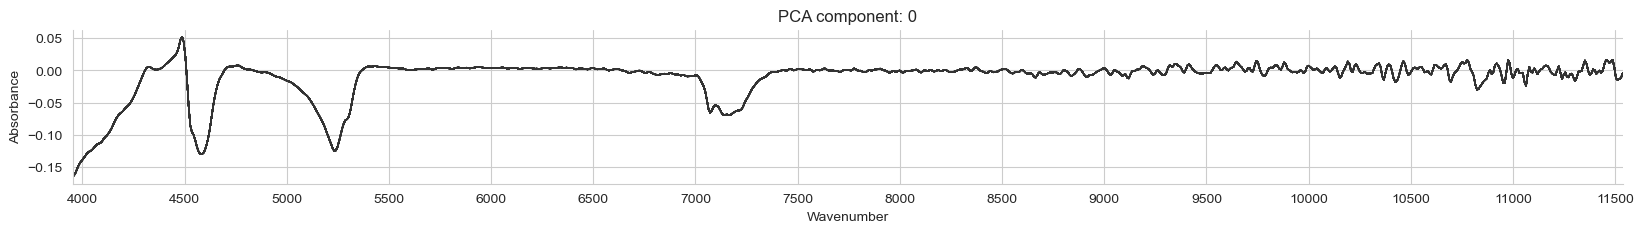

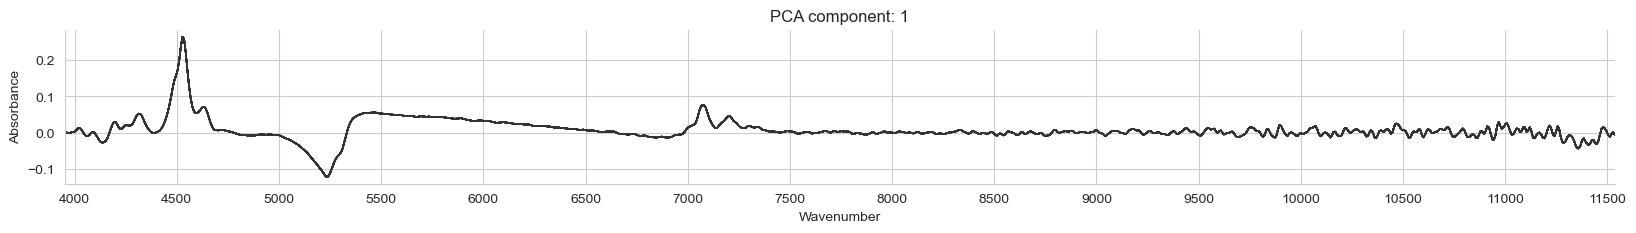

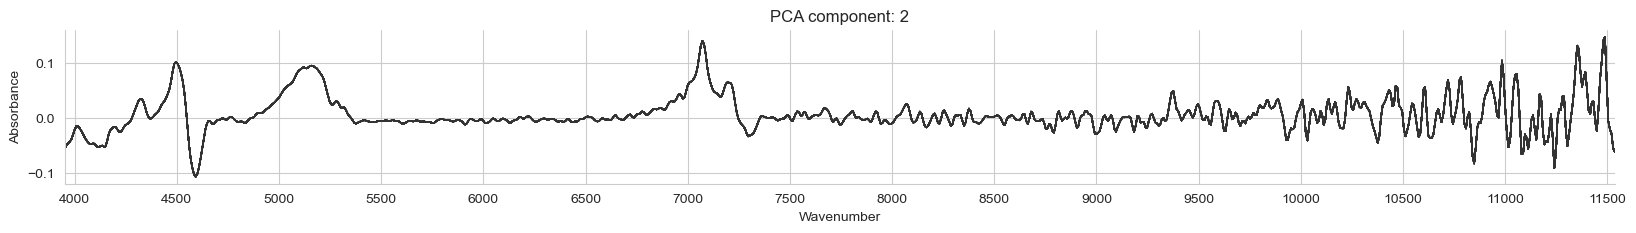

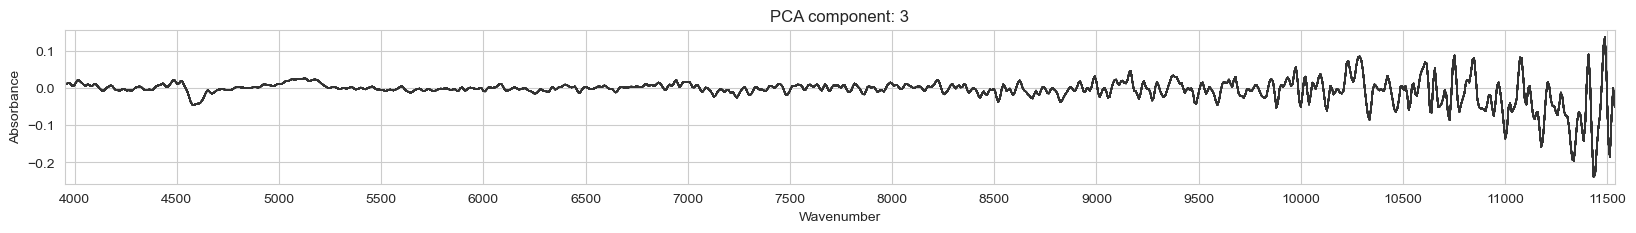

In [698]:
for i in range(4):
    plot_spectra(pca.components_[i,:][None,:], wavenumbers, 
                 alpha=0.8, color='#333', 
                 title=f'PCA component: {i}',
                 ascending=True,
                 figsize=(20, 2))

<Figure size 640x480 with 0 Axes>

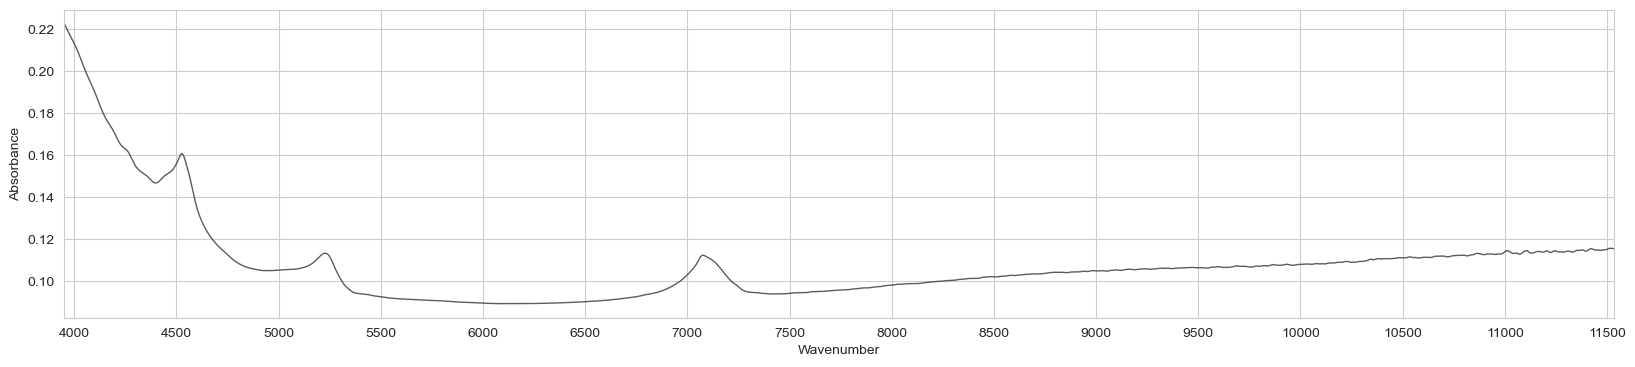

In [618]:
spectrum = X[0]
plot_spectra(spectrum, wavenumbers)

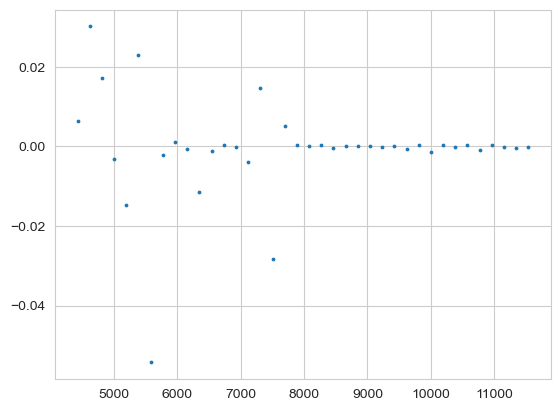

In [655]:
idx = 2
coeffs = pywt.wavedec(spectrum, wavelet_name)
plt.scatter((wavenumbers[::len(wavenumbers)//len(coeffs[idx])])[:len(coeffs[idx])], coeffs[idx], s=3)

In [632]:
len(wavenumbers)//23

41

In [635]:
len(coeffs)

7

In [ ]:

approximation = coeffs[0]  # The first element of the list 'coeffs' is the approximation coefficients

# Detect peaks in the approximation coefficients
# This is a simplistic approach; you might need a more sophisticated peak detection algorithm
peaks, _ = find_peaks(approximation)

# Get peak heights from the original spectrum
# Map peak indices from approximation to original signal, if necessary
# This mapping would depend on the level of decomposition and the wavelet used
original_peaks = peaks * (len(spectrum) // len(approximation))
peak_heights.extend(spectrum[original_peaks])

# Convert list to numpy array
peak_heights = np.array(peak_heights)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(peak_heights, 'x', label='Peak Heights')
plt.xlabel('Sample Index')
plt.ylabel('Peak Height')
plt.title('Peak Heights Extracted from DWT')
plt.legend()
plt.show()

In [617]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
from scipy.signal import find_peaks


spectra = X[
# Assuming 'spectra' is your array of spectral data
# Each row in 'spectra' corresponds to a spectrum

# Choose a wavelet
wavelet_name = 'db5'  # Daubechies wavelet with 5 vanishing moments

# Initialize an array to store peak heights
peak_heights = []

# Perform DWT on each spectrum and detect peaks
for spectrum in spectra:
    # Apply DWT
    coeffs = pywt.wavedec(spectrum, wavelet_name)
    approximation = coeffs[0]  # The first element of the list 'coeffs' is the approximation coefficients

    # Detect peaks in the approximation coefficients
    # This is a simplistic approach; you might need a more sophisticated peak detection algorithm
    peaks, _ = find_peaks(approximation)
    
    # Get peak heights from the original spectrum
    # Map peak indices from approximation to original signal, if necessary
    # This mapping would depend on the level of decomposition and the wavelet used
    original_peaks = peaks * (len(spectrum) // len(approximation))
    peak_heights.extend(spectrum[original_peaks])

# Convert list to numpy array
peak_heights = np.array(peak_heights)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(peak_heights, 'x', label='Peak Heights')
plt.xlabel('Sample Index')
plt.ylabel('Peak Height')
plt.title('Peak Heights Extracted from DWT')
plt.legend()
plt.show()



AxisError: Axis greater than data dimensions